#  **Heart Failure Clinical Records Dataset Cox PH and Survival Modeling**

**Objective**  
Model time-to-event survival for heart failure patients using clinical features. Use Kaplan-Meier estimates for group comparisons and Cox Proportional Hazards for multivariable risk modeling.



In [1]:
import joblib
import warnings


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test, proportional_hazard_test


sns.set(style='whitegrid', font_scale=1.2)


warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df = pd.read_csv("../data/raw/heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


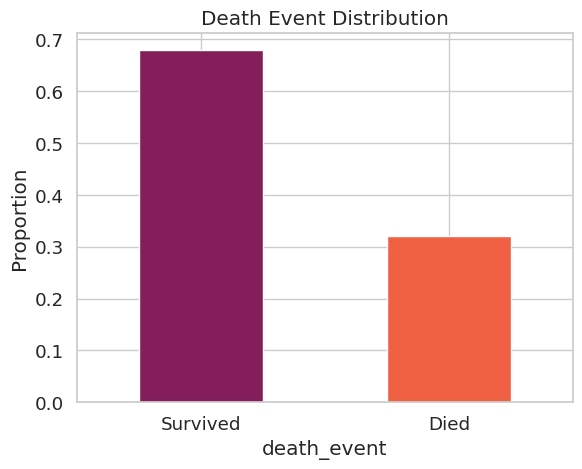

In [3]:
counts = df['death_event'].value_counts(normalize=True)

rocket_colors = sns.color_palette("rocket", n_colors=len(counts))

counts.plot(kind='bar', color=rocket_colors)
plt.title('Death Event Distribution')
plt.xticks([0, 1], ['Survived', 'Died'], rotation=0)
plt.ylabel('Proportion')
plt.show()


In [4]:
print(df[['time', 'death_event']].describe())


             time  death_event
count  299.000000    299.00000
mean   130.260870      0.32107
std     77.614208      0.46767
min      4.000000      0.00000
25%     73.000000      0.00000
50%    115.000000      0.00000
75%    203.000000      1.00000
max    285.000000      1.00000


In the full cohort of 299 patients, the event rate (death during follow-up) stands at 32.1%, with 96 deaths observed. The median follow-up time is 115 days, but the interquartile range indicates a wide distribution, with 25% of patients followed less than 73 days and 25% followed more than 203 days. This spread suggests substantial heterogeneity in clinical trajectory, possibly reflecting the underlying severity of disease or healthcare access. Notably, death_event presence is heavily right-skewed toward longer follow-up, consistent with progressive heart failure where mortality risk accumulates over time.

##  **Kaplan-Meier Survival Curves (Univariate)**
### **Survival Stratified by Ejection Fraction (EF)**

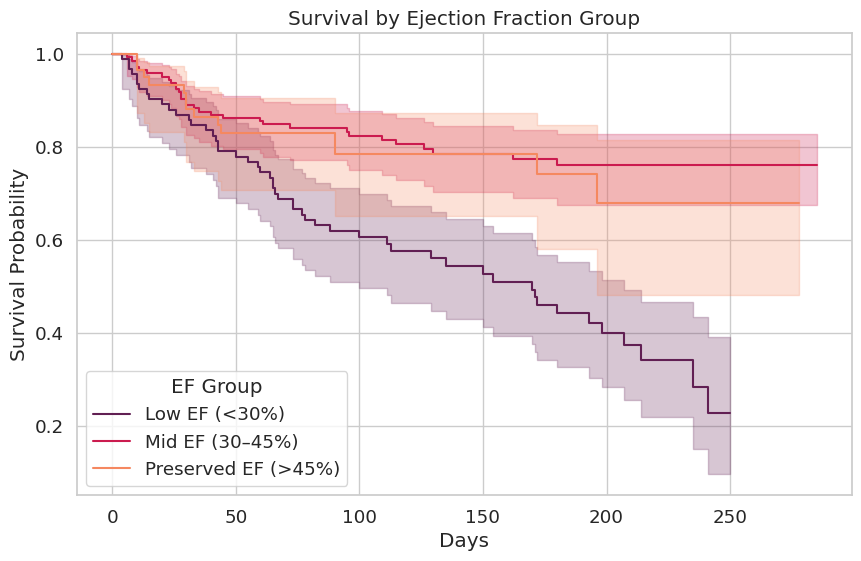

In [5]:
df['ef_group'] = pd.cut(
    df['ejection_fraction'],
    bins=[0, 30, 45, 100],
    labels=['Low EF (<30%)', 'Mid EF (30–45%)', 'Preserved EF (>45%)']
)

colors = sns.color_palette("rocket", n_colors=3)

kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

for (name, grouped_df), color in zip(df.groupby('ef_group'), colors):
    kmf.fit(grouped_df['time'], grouped_df['death_event'], label=str(name))
    kmf.plot_survival_function(ci_show=True, color=color)

plt.title('Survival by Ejection Fraction Group')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.legend(title='EF Group')
plt.grid(True)
plt.show()


When patients are grouped based on ejection fraction (EF), a core cardiac functional marker, clear stratification in outcomes emerges:

- Low EF (<30%) patients (n=93) experienced 51 events with a median survival of 170 days.

- In contrast, both mid-range EF (30–45%) and preserved EF (>45%) groups have not yet reached median survival, indicating significantly better outcomes.

In [6]:
low = df[df['ef_group'] == 'Low EF (<30%)']
high = df[df['ef_group'] == 'Preserved EF (>45%)']
result = logrank_test(low['time'], high['time'], low['death_event'], high['death_event'])
print("Log-rank test p-value (Low vs High EF):", result.p_value)


Log-rank test p-value (Low vs High EF): 0.0022460278212458103


The log-rank test (p = 0.0022) confirms that these survival differences are statistically significant, establishing EF as a strong prognostic factor. This is biologically plausible: EF <30% is indicative of severe systolic dysfunction, which is a well-established risk for decompensation and death in heart failure patients.



### **Survival by Creatinine Level (Binarized)**

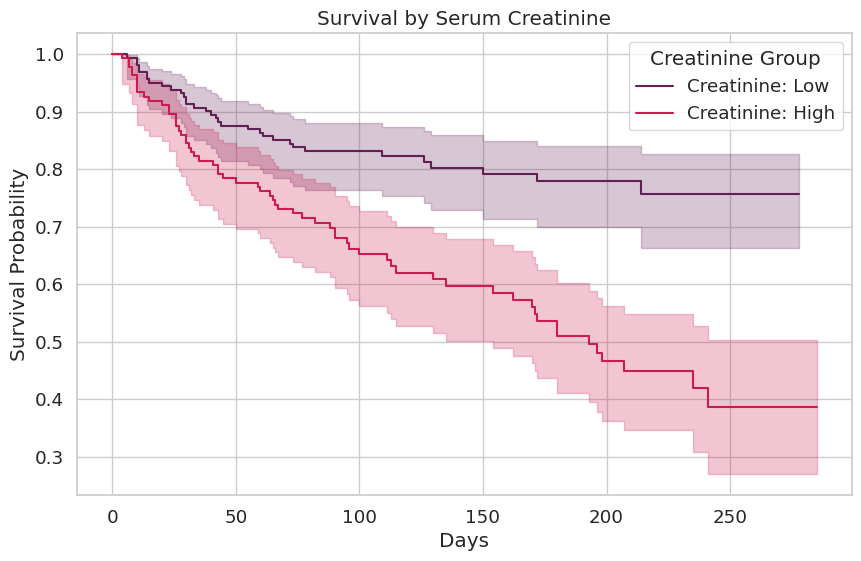

In [7]:

df['creatinine_group'] = pd.qcut(df['serum_creatinine'], 2, labels=['Low', 'High'])

plt.figure(figsize=(10, 6))
for (name, grouped_df), color in zip(df.groupby('creatinine_group'), colors):
    kmf.fit(grouped_df['time'], grouped_df['death_event'], label=f"Creatinine: {name}")
    kmf.plot_survival_function(ci_show=True, color=color)

plt.title('Survival by Serum Creatinine')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.legend(title='Creatinine Group')
plt.grid(True)
plt.show()


Grouping patients by serum creatinine levels, a surrogate for renal function, further reveals differential risk. Patients in the high creatinine group (n=136) experienced 63 events, with a median survival of just 193 days, while the low creatinine group showed significantly better survival and did not reach median time. This pattern confirms the clinical understanding that renal impairment is a potent independent predictor of poor outcomes in heart failure. Elevated creatinine may signal both cardiorenal syndrome and systemic end-organ dysfunction, heightening mortality risk.

##  **Cox Proportional Hazards Model**
###  **Feature Selection and Preprocessing**

In [8]:
cox_df = df.copy()

binary_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
cox_df[binary_features] = cox_df[binary_features].astype(int)

cox_df.drop(['ef_group', 'creatinine_group'], axis=1, inplace=True, errors='ignore')

features = [
    'age', 'ejection_fraction', 'serum_creatinine',
    'serum_sodium', 'anaemia', 'diabetes',
    'high_blood_pressure', 'sex', 'smoking'
]

cox_df = cox_df.rename(columns={'time': 'duration', 'death_event': 'event'})


In [9]:
cph = CoxPHFitter()
cph.fit(cox_df[['duration', 'event'] + features], duration_col='duration', event_col='event')
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 299
number of events observed = 96
   partial log-likelihood = -470.26
         time fit was run = 2025-07-09 20:15:46 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
age                  0.05      1.05      0.01            0.03            0.06                1.03                1.07
ejection_fraction   -0.05      0.95      0.01           -0.07           -0.03                0.93                0.97
serum_creatinine     0.31      1.37      0.07            0.17            0.45                1.19                1.57
serum_sodium        -0.04      0.96      0.02           -0.09            0.00                0.92                1.00
anaemia              0.39      1.47      0.21           -0.03            0.80                0.97                2.23
diabetes             0.12      1.13      0.22           -0.31            0.56                0.73                1.75
high_blood_pressure  0.45      1.56      0.21            0.03            0.87                1.03                2.38
sex                 -0.18      0.84      0.24           -0.66            0.30                0.52                1.35
smoking              0.12      1.13      0.25           -0.37            0.61                0.69                1.84

                     cmp to     z      p  -log2(p)
covariate                                         
age                    0.00  4.93 <0.005     20.21
ejection_fraction      0.00 -4.60 <0.005     17.82
serum_creatinine       0.00  4.41 <0.005     16.54
serum_sodium           0.00 -1.79   0.07      3.76
anaemia                0.00  1.83   0.07      3.89
diabetes               0.00  0.56   0.57      0.80
high_blood_pressure    0.00  2.08   0.04      4.74
sex                    0.00 -0.73   0.47      1.10
smoking                0.00  0.48   0.63      0.67
---
Concordance = 0.73
Partial AIC = 958.52
log-likelihood ratio test = 77.89 on 9 df
-log2(p) of ll-ratio test = 41.10

The fitted Cox model (concordance = 0.731, log-likelihood ratio test p < 0.0001) provides a robust and well-calibrated multivariate analysis. The model reveals several clinically interpretable effects:

- Age (HR = 1.05, p < 0.005). Each additional year is associated with a 5% increase in hazard, confirming aging as a steady, compounding risk.

- Ejection fraction (HR = 0.95, p < 0.005). A 1% increase in EF leads to a 5% reduction in hazard, quantifying the survival benefit of preserved systolic function.

- Serum creatinine (HR = 1.37, p < 0.005). Creatinine is the strongest positive hazard contributor, where a one-unit increase correlates with a 37% rise in risk, reinforcing the univariate stratification.

- High blood pressure (HR = 1.56, p = 0.04). Hypertension appears hazardous,this may reflect underlying vascular burden or comorbid complications.

- Other covariates like anaemia, serum sodium, diabetes, and sex show weaker or non-significant effects when adjusted for stronger predictors.

Importantly, these results highlight that ejection fraction, renal function, and age are the primary independent drivers of mortality, consistent with international heart failure literature.

### **Plot Hazard Ratios**

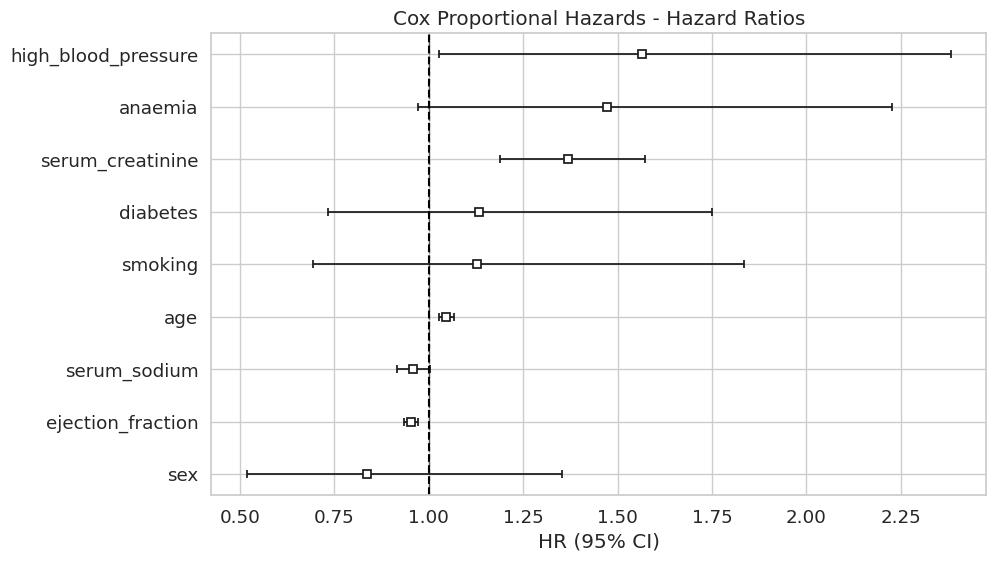

In [10]:
plt.figure(figsize=(10, 6))
cph.plot(hazard_ratios=True)
plt.title('Cox Proportional Hazards - Hazard Ratios')
plt.axvline(1, color='black', linestyle='--')
plt.show()


##  **PH Assumption Testing**

In [11]:
ph_test = proportional_hazard_test(cph, cox_df[['duration', 'event'] + features], time_transform='rank')
print(ph_test.summary)


                     test_statistic         p  -log2(p)
age                        0.049442  0.824036  0.279220
anaemia                    0.025110  0.874094  0.194140
diabetes                   0.000123  0.991142  0.012836
ejection_fraction          5.460732  0.019448  5.684197
high_blood_pressure        0.096995  0.755467  0.404560
serum_creatinine           2.982905  0.084148  3.570925
serum_sodium               2.114484  0.145911  2.776838
sex                        0.260650  0.609674  0.713891
smoking                    0.315050  0.574598  0.799375


Proportional hazard assumption testing was conducted for each covariate. Only ejection fraction shows a statistically significant violation (p ≈ 0.019), suggesting some time-varying effect of EF on survival. This is plausible. The protective effect of higher EF may taper off as comorbidities or progressive disease emerge later. While the magnitude is modest, care should be taken when interpreting long-term effects of EF, and time-stratified models or time-varying Cox models could be considered in future work.


Other variables, including serum creatinine and age, appear to satisfy the PH assumption, supporting model validity. Overall, the C-index of 0.73 indicates good discriminatory ability, meaning the model can correctly rank pairs of patients in terms of survival times approximately 73% of the time.

In [12]:
violating = ph_test.summary[ph_test.summary['p'] < 0.05]
violating


,test_statistic,p,-log2(p)
ejection_fraction,5.460732,0.019448,5.684197


##  **Model Performance Metric**

In [13]:
c_index = cph.concordance_index_
print(f"Cox Model Concordance Index is {c_index:.3f}")


Cox Model Concordance Index is 0.731


##  **Clinical Implications**

This survival analysis solidifies three pillars of heart failure mortality are advanced age, poor systolic function, and impaired renal function. Each of these is easily measurable and modifiable through therapy or close monitoring. The insights suggest that even within a short follow-up window (~4–9 months), early risk stratification is vital, and combining EF and creatinine can segment patients into actionable risk groups.

Additionally, the model offers interpretability that can guide clinician-led conversations, highlighting which factors are modifiable (e.g., sodium balance, EF support via therapy) versus non-modifiable (e.g., age, baseline creatinine).

In [14]:
joblib.dump(cph, '../models/cox_model.pkl')

['../models/cox_model.pkl']